In [1]:
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from dataset import load_dataset_from_path
from datasets import load_dataset, Dataset
from utils import partition_df

/cluster/home/kevidu/micromamba/envs/sftcontext/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
ROOT_DATA_DIR = "../data/Arithmetic/"
RAW_DATA_PATH = os.path.join(ROOT_DATA_DIR, "arithmetic_dataset.csv")
df = load_dataset_from_path(RAW_DATA_PATH)
df = df.drop_duplicates(["query"])
df

,query_no_mod,query,prior_answer,context,ctx_answer,query_depth,ctx_depth
0,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2
1,2 + 0,2 + 0 =,2,0 = 4,6,1,0
2,1 * 6,1 * 6 =,6,1 * 6 = 4,4,1,1
3,8 - 4,8 - 4 =,4,8 - 4 = 9,9,1,1
4,((1 - 4) + 5) + 4,((1 - 4) + 5) + 4 =,6,1 = 0,5,3,0
...,...,...,...,...,...,...,...
4995,((5 + 4) - 0) - 1,((5 + 4) - 0) - 1 =,8,(5 + 4) = 8,7,3,1
4996,((8 - 1) - 3) * 2,((8 - 1) - 3) * 2 =,8,(8 - 1) = 6,6,3,1
4997,((4 * 0) - 0) * 0,((4 * 0) - 0) * 0 =,0,((4 * 0) - 0) * 0 = 3,3,3,3
4998,((0 - 0) + 7) - 3,((0 - 0) + 7) - 3 =,4,((0 - 0) + 7) - 3 = 0,0,3,3


### EDA

In [3]:
df.value_counts(["query"])

query              
((0 * 0) * 8) + 4 =    1
(0 + 2) * 1 =          1
(0 + 3) + 0 =          1
(0 + 2) - 1 =          1
(0 + 2) - 0 =          1
                      ..
((4 - 0) - 8) + 8 =    1
((4 - 0) - 8) + 7 =    1
((4 - 0) - 6) + 8 =    1
((4 - 0) - 4) + 9 =    1
9 - 8 =                1
Name: count, Length: 5000, dtype: int64

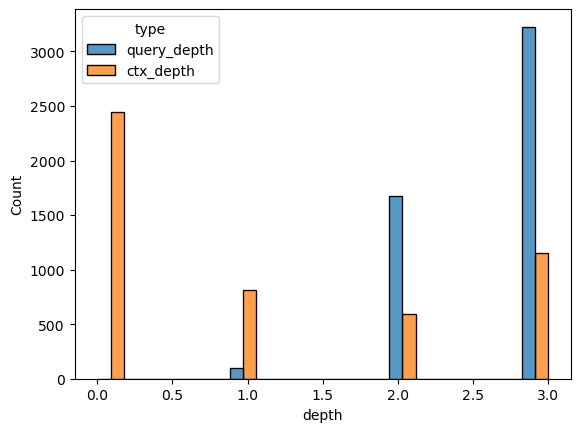

In [4]:
def plot_depth_dist(df):
    fig, ax = plt.subplots()
    sns.histplot(
        data=df.melt(id_vars="query", value_vars=["query_depth", "ctx_depth"], var_name="type", value_name="depth"), 
        x="depth",
        multiple='dodge',
        hue="type",
        ax=ax
    )
plot_depth_dist(df)
# Should we try to even this out more?

### Augment with intent

In [9]:
def interleave_datasets(df1, df2):
    # Ensure df1 and df2 have the same number of rows
    min_rows = min(len(df1), len(df2))
    df1 = df1.iloc[:min_rows]
    df2 = df2.iloc[:min_rows]
    
    # Create a temporary key for sorting
    df1['temp_key'] = np.arange(len(df1)) * 2
    df2['temp_key'] = np.arange(len(df2)) * 2 + 1
    
    # Concatenate and sort
    result = pd.concat([df1, df2]).sort_values('temp_key').reset_index(drop=True)
    
    # Remove the temporary key
    return result.drop('temp_key', axis=1)

In [11]:
df_prior = df.copy()
df_prior["weight_context"] = 0
df_prior["answer"] = df_prior["prior_answer"]

df_ctx = df.copy()
df_ctx["weight_context"] = 1
df_ctx["answer"] = df_ctx["ctx_answer"]

df_all = interleave_datasets(df_prior, df_ctx)
# df_all = pd.concat([df_prior, df_ctx], axis=0)
# df_all.sort_values(["query", "context"])

df_all["answer"] = df_all["answer"].apply(str)
df_all["prior_answer"] = df_all["prior_answer"].apply(str)
df_all["ctx_answer"] = df_all["ctx_answer"].apply(str)
df_all

/scratch/tmp.9123616.kevidu/ipykernel_1841016/855790394.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['temp_key'] = np.arange(len(df1)) * 2
/scratch/tmp.9123616.kevidu/ipykernel_1841016/855790394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temp_key'] = np.arange(len(df2)) * 2 + 1


,query_no_mod,query,prior_answer,context,ctx_answer,query_depth,ctx_depth,weight_context,answer
0,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2,0,5
1,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2,1,9
2,2 + 0,2 + 0 =,2,0 = 4,6,1,0,0,2
3,2 + 0,2 + 0 =,2,0 = 4,6,1,0,1,6
4,1 * 6,1 * 6 =,6,1 * 6 = 4,4,1,1,0,6
...,...,...,...,...,...,...,...,...,...
9995,((4 * 0) - 0) * 0,((4 * 0) - 0) * 0 =,0,((4 * 0) - 0) * 0 = 3,3,3,3,1,3
9996,((0 - 0) + 7) - 3,((0 - 0) + 7) - 3 =,4,((0 - 0) + 7) - 3 = 0,0,3,3,0,4
9997,((0 - 0) + 7) - 3,((0 - 0) + 7) - 3 =,4,((0 - 0) + 7) - 3 = 0,0,3,3,1,0
9998,((0 * 9) + 4) * 1,((0 * 9) + 4) * 1 =,4,((0 * 9) + 4) * 1 = 5,5,3,3,0,4


### Train/val/test split

In [15]:
train_df, val_df, test_df = partition_df(df_all, columns=["query"])
# train_df = train_df.sort_values(["query", "context"])
# val_df = val_df.sort_values(["query", "context"])
# test_df = test_df.sort_values(["query", "context"])

train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    6400 non-null   object
 1   query           6400 non-null   object
 2   prior_answer    6400 non-null   object
 3   context         6400 non-null   object
 4   ctx_answer      6400 non-null   object
 5   query_depth     6400 non-null   int64 
 6   ctx_depth       6400 non-null   int64 
 7   weight_context  6400 non-null   int64 
 8   answer          6400 non-null   object
dtypes: int64(3), object(6)
memory usage: 450.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    1600 non-null   object
 1   query           1600 non-null   object
 2   prior_answer    1600 non-null   object
 3   context         1600 non-nu

(None, None, None)

In [16]:
train_df.value_counts("weight_context")

weight_context
0    3200
1    3200
Name: count, dtype: int64

In [17]:
train_df

,query_no_mod,query,prior_answer,context,ctx_answer,query_depth,ctx_depth,weight_context,answer
0,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2,0,5
1,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2,1,9
2,2 + 0,2 + 0 =,2,0 = 4,6,1,0,0,2
3,2 + 0,2 + 0 =,2,0 = 4,6,1,0,1,6
4,1 * 6,1 * 6 =,6,1 * 6 = 4,4,1,1,0,6
...,...,...,...,...,...,...,...,...,...
6395,((7 + 2) - 4) + 2,((7 + 2) - 4) + 2 =,7,2 = 3,9,3,0,1,9
6396,((8 - 1) - 3) * 2,((8 - 1) - 3) * 2 =,8,(8 - 1) = 6,6,3,1,0,8
6397,((8 - 1) - 3) * 2,((8 - 1) - 3) * 2 =,8,(8 - 1) = 6,6,3,1,1,6
6398,((0 - 0) + 7) - 3,((0 - 0) + 7) - 3 =,4,((0 - 0) + 7) - 3 = 0,0,3,3,0,4


In [9]:
full_dir = os.path.join(ROOT_DATA_DIR, "splits", "base")
os.makedirs(full_dir, exist_ok=True)
train_df.to_csv(
    os.path.join(full_dir, "train.csv"),
    index=False,
)
val_df.to_csv(
    os.path.join(full_dir, "val.csv"),
    index=False,
)
test_df.to_csv(
    os.path.join(full_dir, "test.csv"),
    index=False,
)

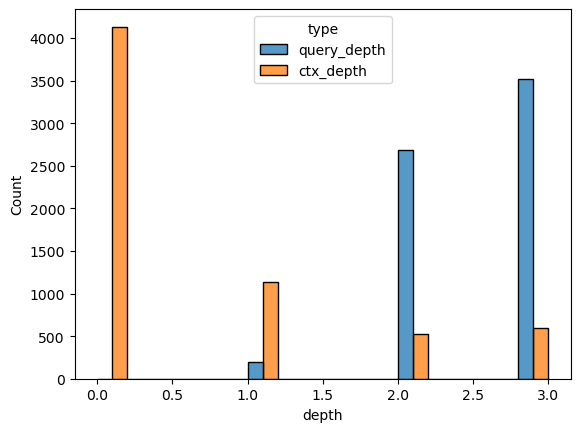

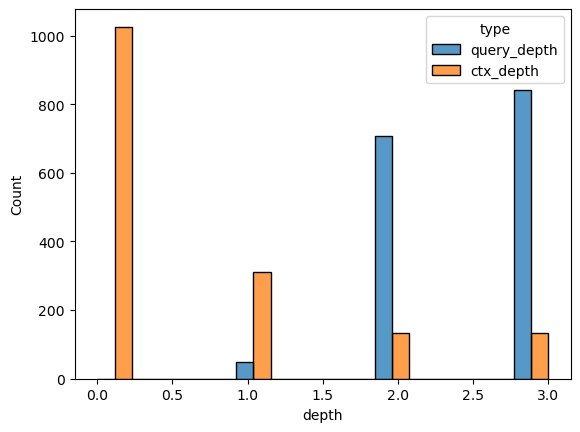

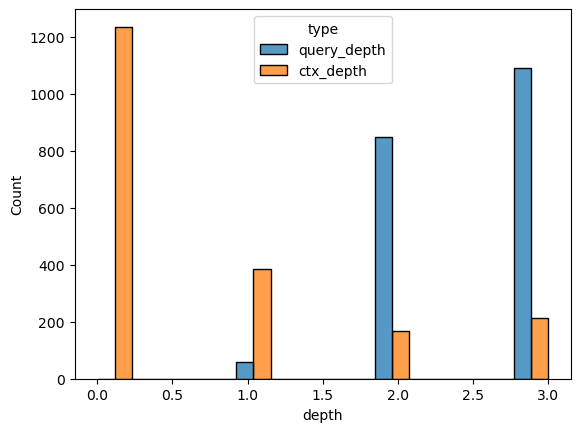

In [10]:
plot_depth_dist(train_df)
plot_depth_dist(val_df)
plot_depth_dist(test_df)
